Baixando nosso banco de dados.

In [1]:
import kagglehub

# Download latest version
kagglehub.dataset_download("ibrahimserouis99/one-piece-image-classifier")
PASTA_MAE = "/root/.cache/kagglehub/datasets/ibrahimserouis99/one-piece-image-classifier/versions/23/Data/Data"

print("\nPath to dataset files:", PASTA_MAE)


Path to dataset files: /root/.cache/kagglehub/datasets/ibrahimserouis99/one-piece-image-classifier/versions/23/Data/Data


In [2]:
# Importações Necessárias
import os
from pprint import pprint

import numpy as np
import random as rd
from matplotlib import pyplot as pp


import tensorflow as tf
import keras
# Não se importe com esses warnings, não resultará em problema.
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

# Início: Preparação dos Dados

### Obtenção dos Caminhos do DataSet

In [3]:
categorias_a_serem_avaliadas = [
    os.path.join(
        PASTA_MAE,
        x
    ) for x in os.listdir(PASTA_MAE) if x in {"Sanji", "Nami"}
]
pprint(categorias_a_serem_avaliadas)

['/root/.cache/kagglehub/datasets/ibrahimserouis99/one-piece-image-classifier/versions/23/Data/Data/Nami',
 '/root/.cache/kagglehub/datasets/ibrahimserouis99/one-piece-image-classifier/versions/23/Data/Data/Sanji']


### Preprocessamento dos Dados

Usaremos o VGG16 que é um modelo de rede neural profunda. Para tanto, precisamos transformar as imagens em um modelo de 224x224 RGB. Além disso, precisamos transformar as imagens em vetores.

In [4]:
def carregar_imagem(
    caminho_imagem: str
) -> tuple[image, np.array]:
    """
    Carrega uma imagem e cria seu vetor correspondente.
    """

    img_carregada = image.load_img(
        caminho_imagem,
        # Necessário para VGG16
        target_size=(224, 224)
    )

    vetor_img = image.img_to_array(
        img_carregada
    )

    vetor_img = np.expand_dims(
        # O método np.expand_dims é usado para adicionar uma nova dimensão
        # a um array NumPy. Ele não altera os dados originais, apenas reorganiza
        # a estrutura do array para que ele tenha uma dimensão a mais na posição
        # especificada pelo parâmetro axis.
        #
        # -> np.array([[1, 2], [3, 4]])  # Matriz original: (2, 2)
        # -> np.expand_dims(matriz, axis=1)
        # -> [[[1 2]],[[3 4]]]  # Matriz expandida: (2, 1, 2)
        vetor_img,
        axis=0
    )

    vetor_img = preprocess_input(
        vetor_img
    )

    return img_carregada, vetor_img

Carregando as imagens completamente.

In [5]:
data = []

for index, categoria in enumerate(categorias_a_serem_avaliadas):
    # Obter primeiro o caminho de todos
    imagens = [
        os.path.join(
            categoria,
            caminho_da_imagem
        ) for caminho_da_imagem in os.listdir(
            categoria
        )
    ]

    for caminho_da_imagem in imagens:

        img_carregada, vetor_img = carregar_imagem(
            caminho_da_imagem
        )

        data.append(
            {
                "x": np.array(
                    vetor_img[0]
                ),
                "y": index
            }
        )

# Adicionamos aleatoriedade na posição dos dados.
rd.shuffle(data)

Separando para teste, validação e treinamento.

In [6]:
# Essa parte definirá tudo.
PROPOR_TREINAMENTO = 0.7

PROPOR_VALIDACAO = (1 - PROPOR_TREINAMENTO) / 2
PROPOR_TESTE = (1 - PROPOR_TREINAMENTO) / 2

# Separando os respectivos array
para_treinamento = data[
    : int(
        PROPOR_TREINAMENTO * len(data)
    )
]
para_validacao = data[
    int(
        PROPOR_TREINAMENTO * len(data)
    ) : int(
        # Meu garoto, isso aqui meu um SANHA que me custou HORAS até eu descobrir.
        # Eu havia esquecido de fazer o slice corretamente.
        # Atentem
        (PROPOR_VALIDACAO + PROPOR_TREINAMENTO) * len(data)
    )
]
para_teste = data[
    int(
        (PROPOR_VALIDACAO + PROPOR_TREINAMENTO) * len(data)
    ) :
]

# Segmentando ainda mais. Infelizmente, terá que ser assim mesmo
x_treino, y_treino = np.array(
    # Observe que x_treino deve ficar entre 0 e 1.
    [
        dado_da_imagem["x"] for dado_da_imagem in para_treinamento
    ]
).astype('float32') / 255, np.array(
    [
        dado_da_imagem["y"] for dado_da_imagem in para_treinamento
    ]
)
x_validacao, y_validacao = np.array(
    [
        dado_da_imagem["x"] for dado_da_imagem in para_validacao
    ]
).astype('float32') / 255, np.array(
    [
        dado_da_imagem["y"] for dado_da_imagem in para_validacao
    ]
)
x_teste, y_teste = np.array(
    [
        dado_da_imagem["x"] for dado_da_imagem in para_teste
    ]
).astype('float32') / 255, np.array(
    [
        dado_da_imagem["y"] for dado_da_imagem in para_teste
    ]
)

# Transformar os rótulos (labels) de classe que normalmente são
# representados por números inteiros (como 0, 1, 2, etc.) em
# vetores binários, onde apenas uma posição é 1 (ativa) e as outras são 0.
# Classe 0 → [1, 0, 0]
# Classe 1 → [0, 1, 0]
y_treino = keras.utils.to_categorical(
    y_treino,
    2  # Afinal, estamos treinando para classificar 2 classes
)
y_validacao = keras.utils.to_categorical(
    y_validacao,
    2
)
y_teste = keras.utils.to_categorical(
    y_teste,
    2
)

# Construindo uma Rede Neural de Classificação do Zero

Antes de aplicar o _Transfer_Learning_, podemos comparar o desempenho com uma rede neural zerada.

Para tanto, vamos criar uma dotada de 4 camadas convolucionais e de agrupamento máximo. Após cada uma adicionaremos um DropOut para evitar overfitting. Após a última camada, adicionaremos mais uma camada densa de 256 neurônios conectados, mais uma de dropout e finalmente a camada de softmax para criar uma curva de distribuição de saída.

In [21]:
modelo = Sequential()

for i in range(4):
    # Na primeira camada
    if not i:
        modelo.add(
            Conv2D(  # Adiciona uma camada convolucional
                32,  # Com 32 filtros
                (3, 3),  # Cada filtro sendo 3x3
                input_shape=x_treino.shape[1:]
            )
        )
    else:
        modelo.add(
            Conv2D(
                32,
                (3, 3)
            )
        )

    modelo.add(
        # Clássica não lineariedade
        Activation("relu")
    )
    modelo.add(
        # Adiciona uma camada de pooling para reduzir as dimensões espaciais pela metade.
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )

    if not (i + 1) % 2:
        modelo.add(
            Dropout(
            # Adiciona uma camada de dropout com taxa de 25%.
            # O dropout "desliga" aleatoriamente 25% dos neurônios
            # durante o treinamento para evitar overfitting.
            0.25
            )
        )


modelo.add(
    # Achata os dados 2D (mapas de características) em um vetor 1D.
    # Isso é necessário para conectar as camadas convolucionais às
    # camadas totalmente conectadas (Dense).
    Flatten()
)
modelo.add(
    # Adiciona uma camada totalmente conectada com 256 neurônios.
    Dense(256)
)
modelo.add(
    # Ainda mais funções de ativação.
    Activation('relu')
)
modelo.add(
    Dropout(0.5)
)

# Última camada que é a classificadora
# Vamos aplicar o softmax para criar uma distribuição de decisão
modelo.add(
    # Os dois neurônios que corresponderão justamente às duas classes.
    Dense(2)
)
modelo.add(
    # Converter as saídas em probabilidades (útil para classificação multiclasse).
    Activation('softmax')
)

modelo.summary(
    # Exibe um resumo da arquitetura do modelo, mostrando o número de parâmetros
    # e o formato de saída de cada camada
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Acabamos de criar um rede de médio porte com ~1,2 milhões de pesos e bias (os parâmetros)

Agora podemos prosseguir e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos traçar a perda ao longo do tempo mais tarde.

In [22]:
# Configuramos o modelo para o treinamento.
modelo.compile(

    # Medirá o quão bem o modelo está performando durante o treinamento.
    # Quanto menor o valor da perda, melhor o modelo está performando.
    # É usada para problemas de classificação onde as classes são
    # mutuamente exclusivas (ou seja, cada amostra pertence a apenas uma classe).
    # Requer que os rótulos (labels) estejam no formato one-hot encoding.
    # Por exemplo, se houver 3 classes, o rótulo da classe 2 seria [0, 1, 0].
    loss='categorical_crossentropy',

    # Adam (Adaptive Moment Estimation) é um otimizador avançado que combina
    # os métodos de momentum e RMSprop, adaptando a taxa de aprendizado de
    # forma dinâmica para cada peso da rede.
    optimizer='adam',

    # Como mediremos o que é melhor, na acurácia.
    metrics=['accuracy']
)

historico = modelo.fit(
    # Usaremos estes para ajustar os pesos
    x_treino, y_treino,

    # IMPORTANTE: Define quantas amostras serão processadas
    # por vez antes de atualizar os pesos do modelo.
    # Trabalhar com todo o conjunto de dados de uma vez pode ser muito pesado,
    # especialmente se você tiver milhares/milhões de amostras.
    # Dividindo em lotes (batches), o treinamento é mais eficiente e rápido.
    batch_size=128,

    # Modelo vai percorrer todo o conjunto de treinamento 10 vezes.
    # Quanto maior o número de épocas, mais tempo o treinamento vai
    # demorar, mas o modelo pode aprender melhor (até certo ponto).
    epochs=10,

    # Usando dados de validação, podemos monitorar se o modelo está
    # melhorando de verdade ou só decorando os dados de treino.
    validation_data=(
        x_validacao, y_validacao
    )
)

# Mlk demora bem mais de 11min.

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - accuracy: 0.5001 - loss: 0.7267 - val_accuracy: 0.6244 - val_loss: 0.6784
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.6289 - loss: 0.6666 - val_accuracy: 0.6294 - val_loss: 0.6210
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.6749 - loss: 0.5848 - val_accuracy: 0.8934 - val_loss: 0.4461
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.8272 - loss: 0.4486 - val_accuracy: 0.9188 - val_loss: 0.2674
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.8765 - loss: 0.3003 - val_accuracy: 0.9137 - val_loss: 0.2007
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.8856 - loss: 0.2804 - val_accuracy: 0.9442 - val_loss: 0.1581
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9258 - loss: 0.1959 - val_accuracy: 0.8985 - val_loss: 0.2226
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.8930 - loss: 0.2672 - val_accuracy: 0.9645 - val_loss: 0.1491
Epoch 9/

Vamos visualizar o quanto a rede pôde aprender.

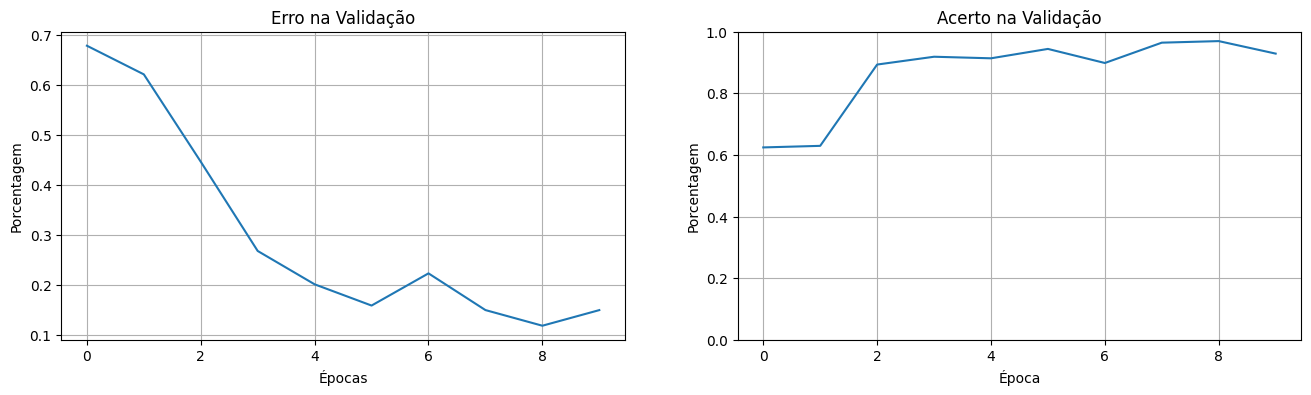

In [23]:
def apresentando_evolucao(historico):
    fig = pp.figure(
        # Vamos plotar informações úteis.
        figsize=(16,4)
    )
    ax = fig.add_subplot(121)
    ax.plot(
        historico.history["val_loss"]
    )
    ax.set_title(
        "Erro na Validação"
    )
    ax.set_ylabel(
        "Porcentagem"
    )
    ax.set_xlabel(
        "Épocas"
    )
    ax.grid(True)

    ax2 = fig.add_subplot(122)
    ax2.plot(historico.history["val_accuracy"])
    ax2.set_title("Acerto na Validação")
    ax2.set_xlabel("Época")
    ax2.set_ylabel("Porcentagem")
    ax2.set_ylim(0, 1)
    ax2.grid(True)

    pp.show()

apresentando_evolucao(
    historico
)

# Observe que a tendência parece sugerir que se "Época -> inf" então a acurácia
# se tornará 100%. Entretanto, ao rever o mesmo banco de dados várias vezes,
# a rede convergirá e não será capaz de aprender coisas novas!
# Sendo assim, faz-se necessário um grande banco de dados, não subestime isso.


Um último teste para nossa rede neural craida do zero.

In [24]:
taxa_de_erro, taxa_de_acerto = modelo.evaluate(
    x_teste, y_teste,
    # Define o nível de exibição do progresso:

    # verbose=0 → Nada será exibido na tela.
    # verbose=1 → Barra de progresso e métricas serão exibidas.
    # verbose=2 → Resumo de cada época (para avaliação, mostra só o resultado final).
    verbose=0
)
print('Taxa de Erro: ', taxa_de_erro)
print('Taxa de Acerto: ', taxa_de_acerto)

Taxa de Erro:  0.14256849884986877
Taxa de Acerto:  0.939393937587738


# Praticando Transfer_Learning

Geralmente, redes neurais profundas são usadas para classificações avançadas. O que faremos é retirar a última camada dessa rede neural profunda e substituí-la conforme for necessário para nós. Note que é como se utilizassemos parte da inteligência que foi previamente obtida neste novo aprendizado.

Agora vamos utilizar uma rede neural já existente e já treinada em suma.

Vamos utilizar o VGG16 do Keras, o qual já foi previamente treinado e tido seus pesos salvados. Caso carregue pela primeira vez, demorará um certo tempo enquanto baixa os dados. Em seguida, veremos um resumo da rede.

## Carregando Super Modelo

In [7]:
model_vgg = keras.applications.VGG16(
    # A plataforma imagenet já treinou a rede.
    weights='imagenet',
    include_top=True
)
model_vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

É óbvio como o VGG16 é MUITO maior que a rede que contruímos, contendo 13 camadas convolucionais, duas últimas camadas totalmente conectadas e, ao todo,
138 milhões de parâmetros.

Para utilizar esta rede neural insana, removemos a última camada que o Imagenet
obteve e substituiremos por uma nova cama de 2 neurônios.


In [9]:
# Obtemos a camada de input
camada_de_entrada = model_vgg.input

# Construimos uma nova última camada
nova_ultima_camada = Dense(
    2,
    activation="softmax"
)

# Conectaremos esta nova última camada à penúltima camada
nova_saida = nova_ultima_camada(
    model_vgg.layers[-2].output
)

# Note como conectamos todo a rede à nova última camada.
# Em seguida, ligamos a entrada à rede.
# Criando a nova rede neural.
novo_modelo = Model(camada_de_entrada, nova_saida)

novo_modelo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 134,268,738 (512.19 MB)

 Non-trainable params: 0 (0.00 B)

Precisamos congelar os pesos e parâmetros em todas as camadas da rede, exceto a nova última camada no final, com a esperança de que os recursos que foram aprendidos no VGG pela ImageNet ainda sejam razoavelmente relevantes para a nova atividade de classificação de imagens.

In [10]:
index_da_camada = 0

# Definirá a partir de qual index não desejamos mais
# o congelamento das camadas.
quantas_ultimas_camadas_nao_serao_congeladas = 1

for camada in novo_modelo.layers:
    if index_da_camada < (len(novo_modelo.layers) - quantas_ultimas_camadas_nao_serao_congeladas):
        camada.trainable = False
    else:
        # Garantir que serão treinadas
        camada.trainable = True

    index_da_camada += 1

novo_modelo.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

novo_modelo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Obseve como agora temos parâmetros não treináveis.

## Treinando

Finalmente, treinar o modelo.
Que em outras palavras significa: perca seu tempo.

In [12]:
novo_historico = novo_modelo.fit(
    x_treino, y_treino,

    batch_size=96,

    epochs=10,
    validation_data=(x_validacao, y_validacao)
    # MLK ISSO DEMOROU TEMPO PARA UM CARALHO.
    # Você não tem ideia, demorou MUITO FILHO
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 586s 59s/step - accuracy: 0.4872 - loss: 1.0731 - val_accuracy: 0.5127 - val_loss: 0.6829
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 658s 63s/step - accuracy: 0.5912 - loss: 0.6390 - val_accuracy: 0.6802 - val_loss: 0.5532
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 588s 60s/step - accuracy: 0.7910 - loss: 0.5046 - val_accuracy: 0.8426 - val_loss: 0.4452
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 656s 63s/step - accuracy: 0.8362 - loss: 0.4404 - val_accuracy: 0.8528 - val_loss: 0.4050
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 622s 63s/step - accuracy: 0.8445 - loss: 0.4044 - val_accuracy: 0.8680 - val_loss: 0.3782
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 623s 63s/step - accuracy: 0.8576 - loss: 0.3754 - val_accuracy: 0.8629 - val_loss: 0.3715
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 621s 63s/step - accuracy: 0.8499 - loss: 0.3728 - val_accuracy: 0.8883 - val_loss: 0.3486
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 621s 63s/step - accuracy: 0.8735 - loss: 0.3313 - val_accuracy: 0.

Vamos apresentar como o modelo evoluiu.

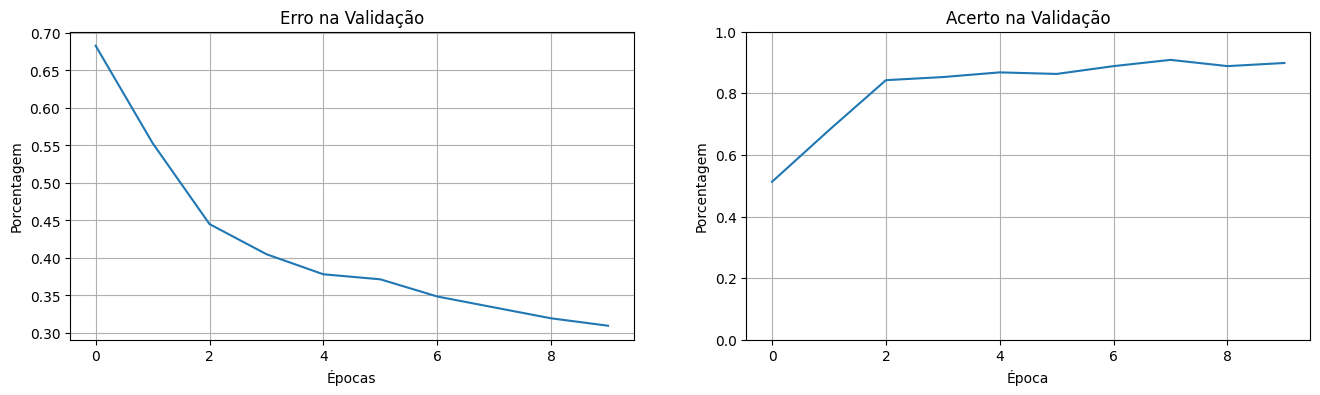

In [14]:
apresentando_evolucao(
    novo_historico
)

Último teste

In [15]:
taxa_de_erro, taxa_de_acerto = novo_modelo.evaluate(x_teste, y_teste, verbose=0)

print('Taxa de Erro:', taxa_de_erro)
print('Taxa de Acerto:', taxa_de_acerto)

Test loss: 0.24770796298980713
Test accuracy: 0.939393937587738


# Finalização

Observe que o super modelo rapidamente convergiu para um estado ideal.